In [1]:
import tensorflow as tf
import keras
from tensorflow.keras.utils import load_img, img_to_array, array_to_img
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Dense
from keras.layers.core import Dropout
from keras.layers.core import Flatten
from keras.models import Sequential
from keras.models import model_from_json
from keras.callbacks import LearningRateScheduler
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.utils import np_utils
import glob         
import sys
import numpy as np
import matplotlib.pyplot as plt
import PIL
from PIL import Image
import cv2
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings("ignore") 
import mymodule
from mymodule import BatchGenerator
from mymodule import Make_Raw_List2
from mymodule import plot_loss_accuracy_graph
import shutil
import os

In [4]:
# Hyper Parameter
BATCH_SIZE   = 32
NUM_CLASSES  = 2
EPOCHS       = 16
class_name   = ["Normal",'abnormal']

#imgsize
IMG_ROWS     = 768
IMG_COLS     = 1024
IMG_CHANNELS = 3

#Input File
csv_filename = "data.csv"
image_folder = "./img"

#Output File
best_model_path = 'best_model_path_an_simple.h5'
final_model_path = 'final_model_path.h5'
output_file = 'model.summary.txt'

In [5]:
import pandas as pd
df=pd.read_csv(csv_filename)
df

,filename,ID,age,sex,LR,AMD,RVO,Gla,MH,DR,RD,RP,AO,DM
0,000000_00.jpg,3090,78,M,L,0,0,0,0,0,0,0,0,0
1,000000_01.jpg,3090,78,M,R,0,0,0,0,0,0,0,0,0
2,000001_00.jpg,2702,76,F,L,0,0,0,0,0,0,0,0,0
3,000001_01.jpg,2702,76,F,R,0,0,0,0,0,0,0,0,0
4,000001_02.jpg,1136,69,M,L,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13042,005387_01.jpg,3657,73,F,L,0,0,0,0,0,0,0,0,0
13043,005387_02.jpg,173,73,F,R,0,0,0,0,0,0,0,0,0
13044,005387_03.jpg,3156,71,F,R,0,0,0,0,0,0,0,0,0
13045,005388_00.jpg,3156,71,F,L,0,0,0,0,0,0,0,0,0


In [6]:
#1: healthy, 0:abnormal
def health(x):
    if x!=0:
        a=0
    else:
        a=1
    return a

def unhealth(x):
    if x!=0:
        a=1
    else:
        a=0
    return a

In [7]:
df['HE_on']=df['AMD']+df['RVO']+df['Gla']+df['MH']+df['DR']+df['RD']+df['RP']+df['AO']+df['DM']
df['HE']=df['HE_on'].apply(lambda x: health(x))
df['unHE']=df['HE_on'].apply(lambda x: unhealth(x))
df

,filename,ID,age,sex,LR,AMD,RVO,Gla,MH,DR,RD,RP,AO,DM,HE_on,HE,unHE
0,000000_00.jpg,3090,78,M,L,0,0,0,0,0,0,0,0,0,0,1,0
1,000000_01.jpg,3090,78,M,R,0,0,0,0,0,0,0,0,0,0,1,0
2,000001_00.jpg,2702,76,F,L,0,0,0,0,0,0,0,0,0,0,1,0
3,000001_01.jpg,2702,76,F,R,0,0,0,0,0,0,0,0,0,0,1,0
4,000001_02.jpg,1136,69,M,L,0,0,1,0,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13042,005387_01.jpg,3657,73,F,L,0,0,0,0,0,0,0,0,0,0,1,0
13043,005387_02.jpg,173,73,F,R,0,0,0,0,0,0,0,0,0,0,1,0
13044,005387_03.jpg,3156,71,F,R,0,0,0,0,0,0,0,0,0,0,1,0
13045,005388_00.jpg,3156,71,F,L,0,0,0,0,0,0,0,0,0,0,1,0


In [8]:
#generate the y label
teacher_array=np.array(df.iloc[:,-2:])
teacher_array[2]

array([1, 0])

In [9]:
#create the column for the image path array
df['tem']='./img/'
df['img']=df['tem']+df['filename']
df

,filename,ID,age,sex,LR,AMD,RVO,Gla,MH,DR,RD,RP,AO,DM,HE_on,HE,unHE,tem,img
0,000000_00.jpg,3090,78,M,L,0,0,0,0,0,0,0,0,0,0,1,0,./img/,./img/000000_00.jpg
1,000000_01.jpg,3090,78,M,R,0,0,0,0,0,0,0,0,0,0,1,0,./img/,./img/000000_01.jpg
2,000001_00.jpg,2702,76,F,L,0,0,0,0,0,0,0,0,0,0,1,0,./img/,./img/000001_00.jpg
3,000001_01.jpg,2702,76,F,R,0,0,0,0,0,0,0,0,0,0,1,0,./img/,./img/000001_01.jpg
4,000001_02.jpg,1136,69,M,L,0,0,1,0,0,0,0,0,0,1,0,1,./img/,./img/000001_02.jpg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13042,005387_01.jpg,3657,73,F,L,0,0,0,0,0,0,0,0,0,0,1,0,./img/,./img/005387_01.jpg
13043,005387_02.jpg,173,73,F,R,0,0,0,0,0,0,0,0,0,0,1,0,./img/,./img/005387_02.jpg
13044,005387_03.jpg,3156,71,F,R,0,0,0,0,0,0,0,0,0,0,1,0,./img/,./img/005387_03.jpg
13045,005388_00.jpg,3156,71,F,L,0,0,0,0,0,0,0,0,0,0,1,0,./img/,./img/005388_00.jpg


In [10]:
img_path_array=np.array(df.iloc[:,-1])
img_path_array

array(['./img/000000_00.jpg', './img/000000_01.jpg',
       './img/000001_00.jpg', ..., './img/005387_03.jpg',
       './img/005388_00.jpg', './img/005388_01.jpg'], dtype=object)

In [11]:
#train test split
train_img_path,test_img_path,train_teacher,test_teacher = train_test_split(img_path_array,teacher_array,
                                                                test_size=0.2,shuffle=True,random_state=0)

train_img_path,val_img_path,train_teacher,val_teacher = train_test_split(train_img_path,train_teacher,
                                                                test_size=0.25,shuffle=True,random_state=0)

In [9]:
#image shape
if keras.backend.image_data_format == "channels_first":
    IMG_SHAPE   = (IMG_CHANNELS,IMG_ROWS,IMG_COLS)
else:
    IMG_SHAPE   = (IMG_ROWS,IMG_COLS,IMG_CHANNELS)

print("debugpoint2")

debugpoint2


In [7]:
#get the path
root=os.getcwd()

In [13]:
#train, validation, test batch generator
train_batch_generator = BatchGenerator(train_img_path,train_teacher,IMG_SHAPE,BATCH_SIZE)
val_batch_generator = BatchGenerator(val_img_path,val_teacher,IMG_SHAPE,BATCH_SIZE)
test_batch_generator = BatchGenerator(test_img_path,test_teacher,IMG_SHAPE,BATCH_SIZE)
print("debugpoint3")

debugpoint3


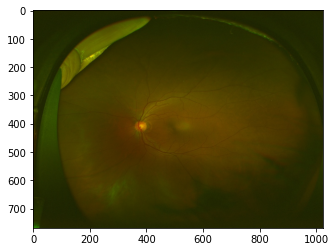

In [18]:
#show sample image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread(root+'/img/004860_00.jpg')
imgplot = plt.imshow(img)
plt.show()

In [14]:
#for the sample image above, get the batch generator, for test
test_teacher_s=np.array([0,1])
test_s = BatchGenerator(root+'/img/004860_00.jpg',test_teacher_s,IMG_SHAPE,1)
test_s

In [14]:
#build the simple CNN model
model = Sequential()
model.add(MaxPooling2D(pool_size=(2,2), input_shape=IMG_SHAPE))
model.add(Conv2D(32,kernel_size=(8,8),activation='relu'))
model.add(MaxPooling2D(pool_size=(4,4)))
model.add(Conv2D(64,kernel_size=(16,16),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(16,kernel_size=(3,3),activation='relu'))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(128,activation='relu'))
#model.add(Dense(128,activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(32,activation='relu'))
model.add(Dense(NUM_CLASSES,activation='softmax'))

model.summary()

print("debugpoint4")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 max_pooling2d (MaxPooling2D  (None, 384, 512, 3)      0         
 )                                                               
                                                                 
 conv2d (Conv2D)             (None, 377, 505, 32)      6176      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 94, 126, 32)      0         
 2D)                                                             
                                                                 
 conv2d_1 (Conv2D)           (None, 79, 111, 64)       524352    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 39, 55, 64)       0         
 2D)                                                             
                                                        

2022-11-20 21:22:52.186343: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [15]:
#compile the model, create the check point
with open(output_file,"w") as fp:
    model.summary(print_fn=lambda x:fp.write(x + "\r\n"))

model.compile(optimizer=keras.optimizers.Nadam(),
            loss=keras.losses.categorical_crossentropy,
            metrics=['accuracy'])

chk_point = keras.callbacks.ModelCheckpoint(filepath=best_model_path,monitor='val_accuracy',
                                            verbose=1,save_best_only=True, save_weights_only=False,
                                            mode='max',save_freq='epoch')

print("debugpoint5")

debugpoint5


In [128]:
#train the model
fit_record = model.fit_generator(train_batch_generator,epochs=EPOCHS,
                                steps_per_epoch=train_batch_generator.batches_per_epoch,
                                verbose=1,validation_data=val_batch_generator,
                                validation_steps=test_batch_generator.batches_per_epoch,
                                shuffle=False,callbacks=[chk_point])

print("debugpoint6")

Epoch 1/5
245/245 [==============================] - ETA: 0s - loss: 0.6657 - accuracy: 0.6587
Epoch 1: val_accuracy improved from -inf to 0.66245, saving model to best_model_path.h5
245/245 [==============================] - 2234s 9s/step - loss: 0.6657 - accuracy: 0.6587 - val_loss: 0.5733 - val_accuracy: 0.6625
Epoch 2/5
245/245 [==============================] - ETA: 0s - loss: 0.5574 - accuracy: 0.6945
Epoch 2: val_accuracy improved from 0.66245 to 0.69464, saving model to best_model_path.h5
245/245 [==============================] - 2278s 9s/step - loss: 0.5574 - accuracy: 0.6945 - val_loss: 0.5515 - val_accuracy: 0.6946
Epoch 3/5
245/245 [==============================] - ETA: 0s - loss: 0.5645 - accuracy: 0.7261
Epoch 3: val_accuracy improved from 0.69464 to 0.70575, saving model to best_model_path.h5
245/245 [==============================] - 2384s 10s/step - loss: 0.5645 - accuracy: 0.7261 - val_loss: 0.5455 - val_accuracy: 0.7057
Epoch 4/5
245/245 [==========================

In [ ]:
# save the model
model.save(final_model_path)

In [129]:
# test the learned model
test_model = keras.models.load_model(best_model_path)

test_result=test_model.predict_generator(test_batch_generator, steps=None, max_queue_size=10,
                                        workers=1,use_multiprocessing=False, verbose=1)

predict = np.argmax(test_result,axis=1)
true_label = np.argmax(test_teacher,axis=1)

print("debugpoint7")

82/82 [==============================] - 162s 2s/step
debugpoint7


test_result
[[0.28195003 0.7180499 ]
 [0.28538474 0.7146152 ]
 [0.5957618  0.40423825]
 ...
 [0.03052431 0.9694756 ]
 [0.01701712 0.9829829 ]
 [0.00961829 0.99038166]]
test_result.shape=(2610, 2)
predict
[1 1 0 ... 1 1 1]
predict.shape=(2610,)
true_label
[1 0 1 ... 1 1 1]
true_label.shape=(2610,)
              precision    recall  f1-score   support

      Normal       0.61      0.58      0.60       863
    abnormal       0.80      0.82      0.81      1747

    accuracy                           0.74      2610
   macro avg       0.71      0.70      0.70      2610
weighted avg       0.74      0.74      0.74      2610



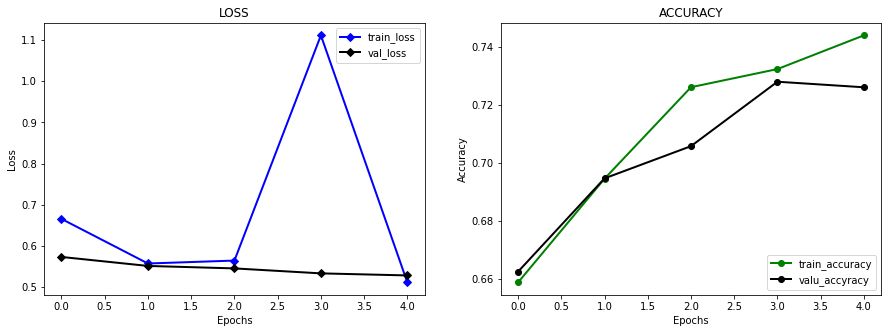

In [130]:
#test result
print("test_result")
print(test_result)
print("test_result.shape={}".format(test_result.shape))

print("predict")
print(predict)
print("predict.shape={}".format(predict.shape))

print("true_label")
print(true_label)
print("true_label.shape={}".format(true_label.shape))

print(classification_report(true_label,predict,target_names=class_name))

plot_loss_accuracy_graph(fit_record)

In [19]:
import cv2

In [23]:
test_ss=cv2.imread(root+'/img/004860_00.jpg')
test_ss = test_ss.reshape((1,) + test_ss.shape)
test_ss.shape

(1, 768, 1024, 3)

In [24]:
# test the single sample data
test_model = keras.models.load_model(best_model_path)

test_result=test_model.predict(test_ss)
print(test_result)
# print("test_result.shape={}".format(test_result.shape))

1/1 [==============================] - 0s 218ms/step
[[0.3409161 0.6590839]]


In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np                               # Import numpy
from skimage import data, io   # Import skimage library (data - Test images and example data.
#                          io - Reading, saving, and displaying images.)
from skimage.color import rgb2gray
import matplotlib.pyplot as plt                  # Import matplotlib.pyplot (Plotting framework in Python.)
%matplotlib inline
import os                                        # This module provides a portable way of using operating system dependent functionality.
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import warnings
# Suppress warnings
warnings.filterwarnings('ignore')
from IPython.display import display
import cv2 as cv
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras import utils
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import seaborn as sns

In [2]:
import visualkeras

In [10]:
#create the model, used to plot the architecture of the model
def construct_model():
    model = Sequential()
    model.add(MaxPooling2D(pool_size=(2,2), input_shape=(768,1024,3)))
    model.add(Conv2D(32,kernel_size=(8,8),activation='relu'))
    model.add(MaxPooling2D(pool_size=(4,4)))
    model.add(Conv2D(64,kernel_size=(16,16),activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(16,kernel_size=(3,3),activation='relu'))
    model.add(Dropout(0.3))
    model.add(Flatten())
    model.add(Dense(128,activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(32,activation='relu'))
    model.add(Dense(2,activation='softmax'))
    model.compile(optimizer=keras.optimizers.Nadam(),
            loss=keras.losses.categorical_crossentropy,
            metrics=['accuracy'])
    return model

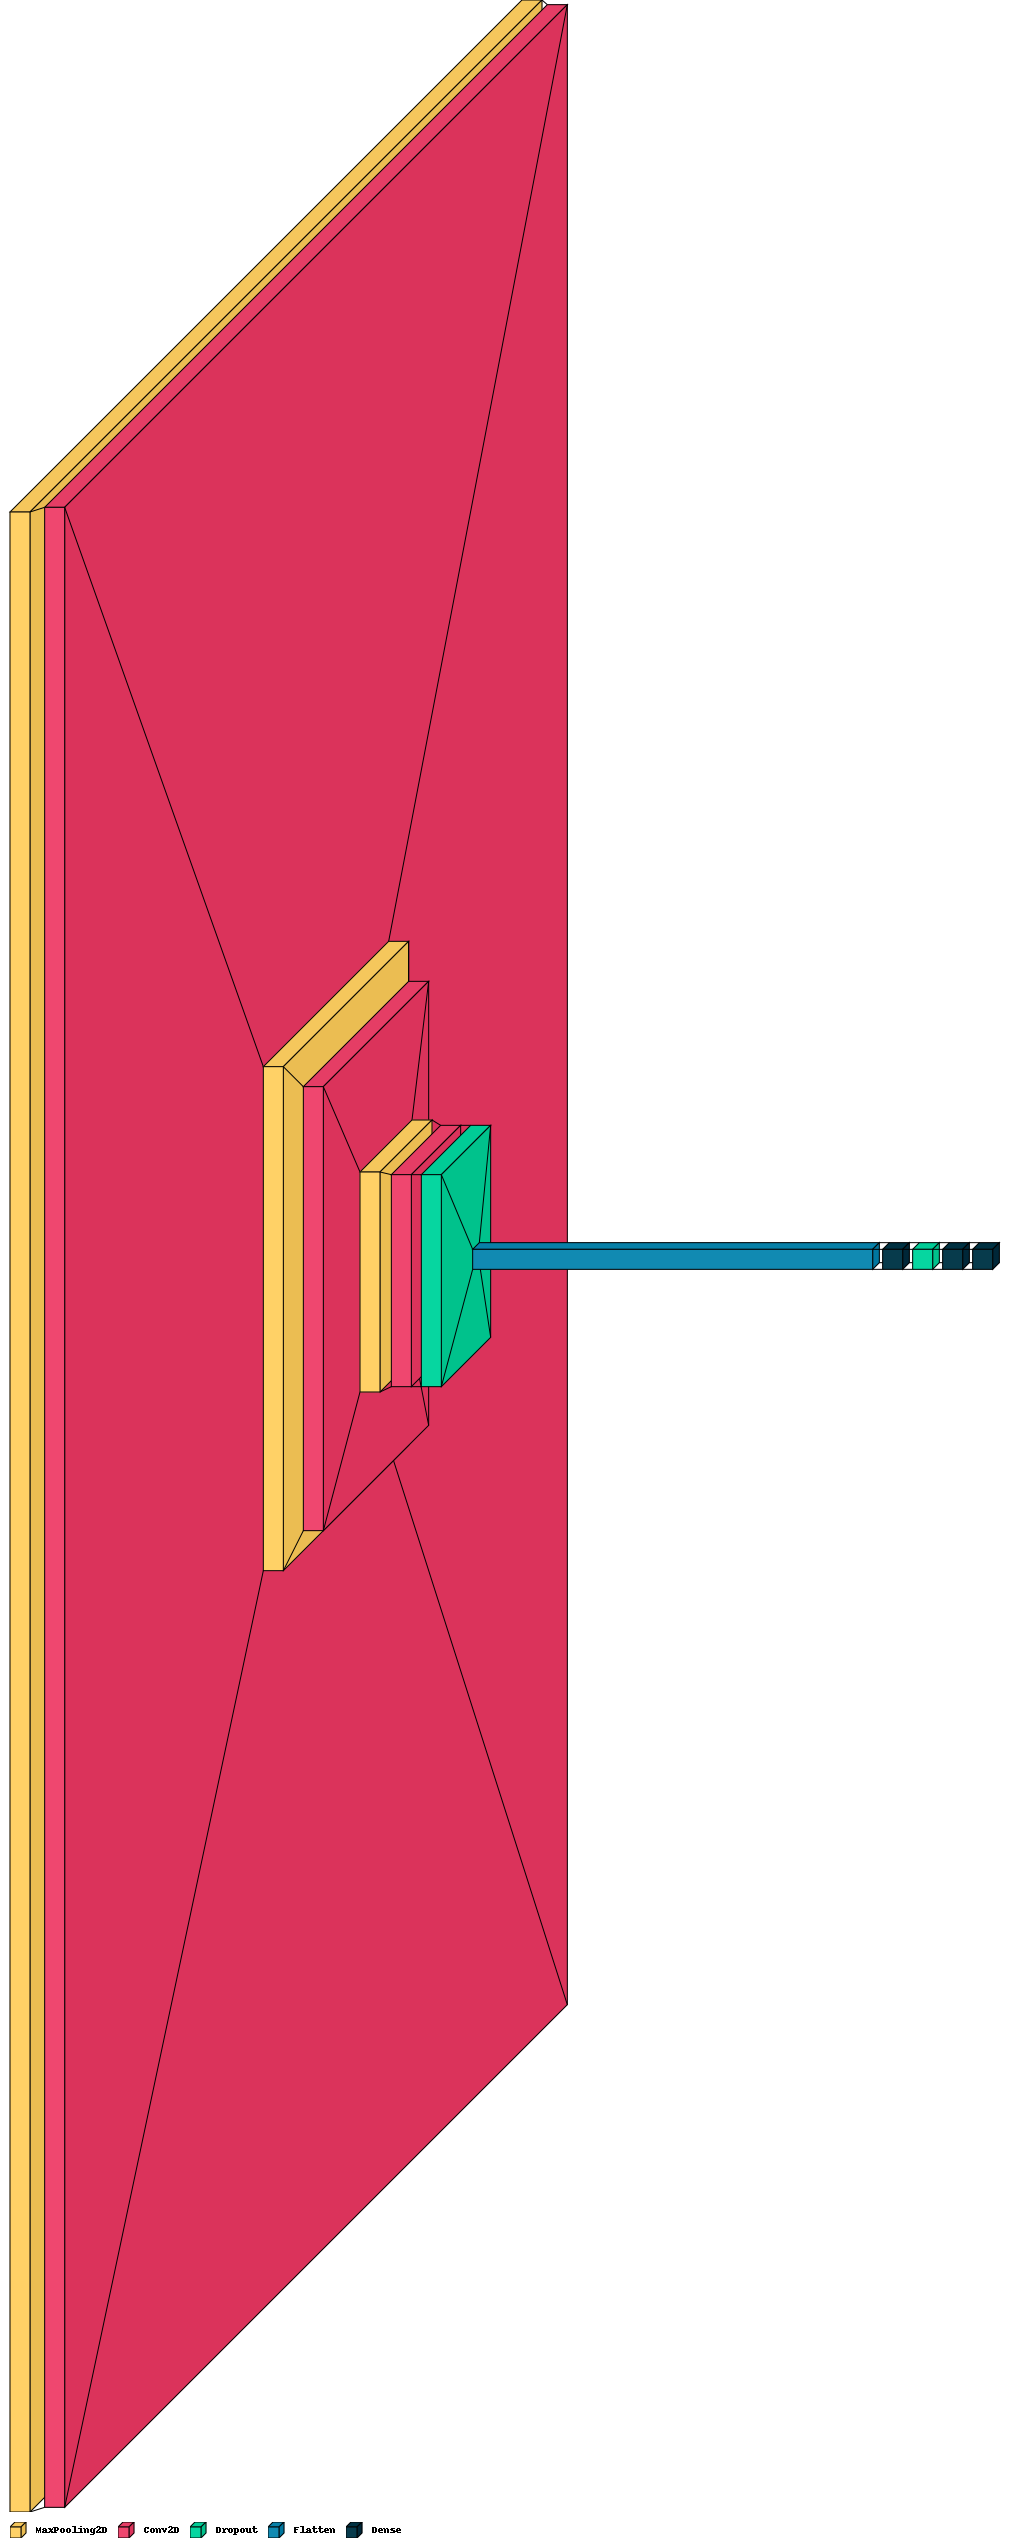

In [11]:
#plot the architecture of the model
model=construct_model()
from PIL import ImageFont
visualkeras.layered_view(model, legend=True)

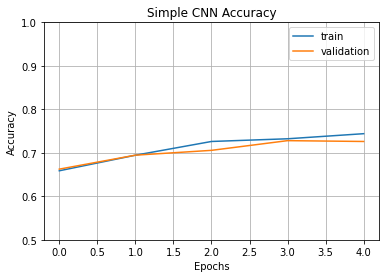

In [4]:
fig1 = plt.gcf()
plt.plot([0.6587,0.6945,0.7261,0.7323,0.7440])
plt.plot([0.6625,0.6946,0.7057,0.7280,0.7261])
plt.axis(ymin=0.5,ymax=1)
plt.grid()
plt.title('Simple CNN Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show() 